In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K


import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random

## Seeding
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
w, h = 256,256
border = 5

# **Data Reading and Train test split**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import glob
train = sorted(glob.glob("/content/drive/MyDrive/Military_Dataset/train/images/*.jpg"))
test = sorted(glob.glob("/content/drive/MyDrive/Military_Dataset/test/images/*.jpg"))
train_mask = sorted(glob.glob("/content/drive/MyDrive/Military_Dataset/train/GT/*.jpg"))
test_mask = sorted(glob.glob("/content/drive/MyDrive/Military_Dataset/test/GT/*.png"))

train = sorted(train + test)
train_mask = sorted(train_mask + test_mask)

print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 1078
Total Mask Image : 1078


In [ ]:
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [ ]:
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X[n] = x_img/255.0
  y[n] = mask/255.0

0it [00:00, ?it/s]

In [ ]:
# # Save the files in Numpy array for reusability
# np.save('/content/drive/MyDrive/Military_Dataset/X.npy', X)
# np.save('/content/drive/MyDrive/Military_Dataset/y.npy', y)
# print(X.shape, y.shape)
X = np.load('/content/drive/MyDrive/Military_Dataset/X.npy')
y = np.load('/content/drive/MyDrive/Military_Dataset/y.npy')
print(X.shape, y.shape)

(1078, 256, 256, 3) (1078, 256, 256, 1)


In [ ]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(970, 256, 256, 3) (970, 256, 256, 1) (108, 256, 256, 3) (108, 256, 256, 1)


22

# **Visualization the image and It masks**

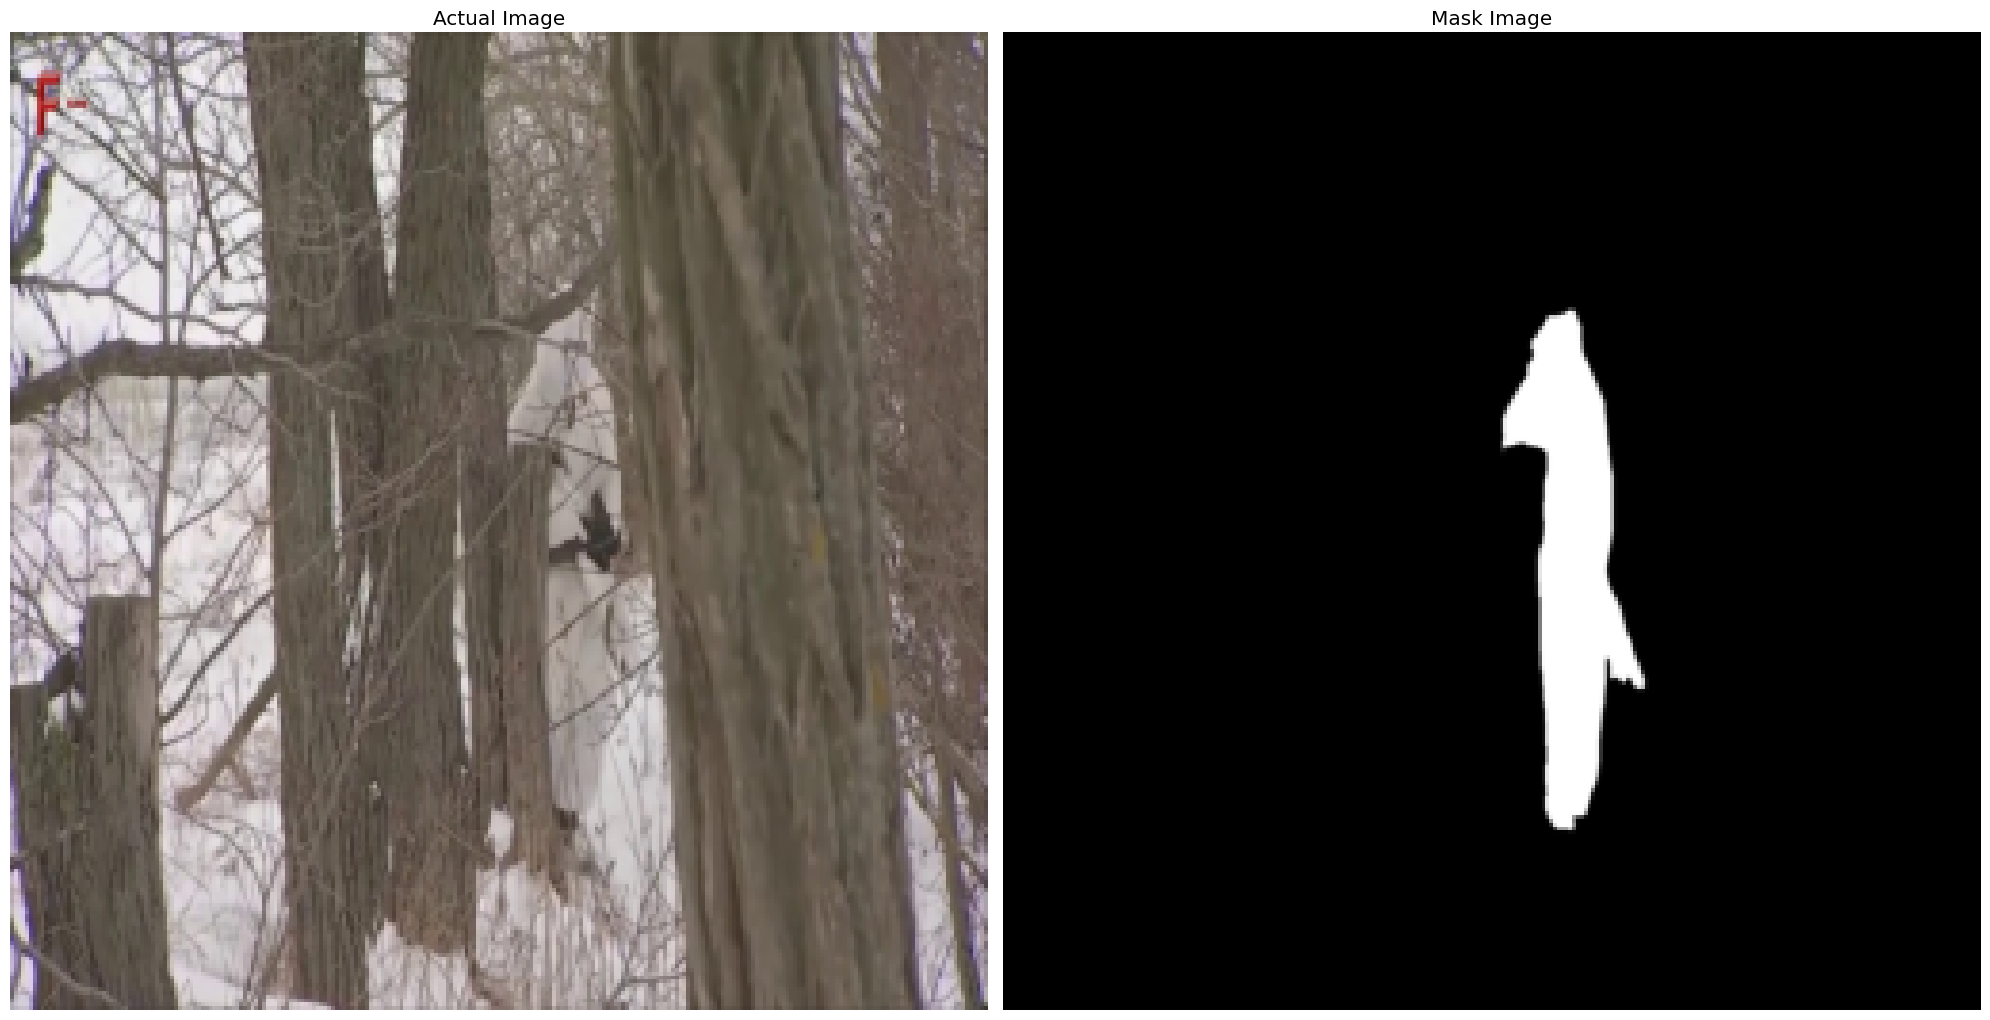

In [ ]:
import matplotlib.pyplot as plt

ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))

# Check for grayscale image and handle channels accordingly
if len(X_train.shape) == 3 and X_train.shape[2] == 3:
    ax1.imshow(X_train[ix])
else:
    ax1.imshow(X_train[ix], cmap='gray')

# if has_mask:
#     ax1.contour(y_train[ix].squeeze(), colors='k', linewidths=5, levels=[0.5])

ax1.set_title('Actual Image')
ax1.set_axis_off()

ax2.imshow(y_train[ix].squeeze(), cmap='gray')
ax2.set_title('Mask Image')
ax2.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
valset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [ ]:
def Unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
from keras import backend as K
K.clear_session()

input_img = Input((h, w, 3), name='img')
model = Unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
metrics = ["accuracy",
           tf.keras.metrics.AUC(),
           tf.keras.metrics.SensitivityAtSpecificity(0.5),
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()

450

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         448       ['img[0][0]']                 
                                                                                                  
 batch_normalization_1 (Bat  (None, 256, 256, 16)         64        ['conv2d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_1 (Activation)   (None, 256, 256, 16)         0         ['batch_normalization_1[0]

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=6, epochs=40, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/40
162/162 [==============================] - ETA: 0s - loss: 0.4817 - accuracy: 0.7089 - auc: 0.6937 - sensitivity_at_specificity: 0.7586 - specificity_at_sensitivity: 0.7669
Epoch 1: val_loss improved from inf to 0.45881, saving model to model-Unet.h5
162/162 [==============================] - 34s 95ms/step - loss: 0.4817 - accuracy: 0.7089 - auc: 0.6937 - sensitivity_at_specificity: 0.7586 - specificity_at_sensitivity: 0.7669 - val_loss: 0.4588 - val_accuracy: 0.7637 - val_auc: 0.6211 - val_sensitivity_at_specificity: 0.6388 - val_specificity_at_sensitivity: 0.6269 - lr: 0.0010
Epoch 2/40
161/162 [============================>.] - ETA: 0s - loss: 0.3541 - accuracy: 0.7712 - auc: 0.7835 - sensitivity_at_specificity: 0.8511 - specificity_at_sensitivity: 0.8854
Epoch 2: val_loss improved from 0.45881 to 0.36156, saving model to model-Unet.h5
162/162 [==============================] - 11s 67ms/step - loss: 0.3543 - accuracy: 0.7712 - auc: 0.7840 - sensitivity_at_specificity: 0.8

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

loss  accuracy       auc  sensitivity_at_specificity  \
16  0.247747  0.816029  0.853842                    0.893187   
26  0.166975  0.849423  0.888047                    0.903100   
24  0.174895  0.846716  0.888352                    0.910210   
18  0.231083  0.821984  0.860497                    0.897809   
23  0.178772  0.845441  0.886092                    0.910089   
14  0.257138  0.811010  0.849256                    0.885660   
13  0.257621  0.810759  0.847834                    0.888949   
22  0.185594  0.842057  0.882266                    0.893301   
9   0.284989  0.799958  0.834112                    0.882707   
25  0.169267  0.848800  0.887711                    0.905193   
11  0.276214  0.802382  0.836009                    0.881093   
10  0.278605  0.801775  0.835535                    0.885676   
21  0.212877  0.830604  0.872351                    0.895871   
20  0.215508  0.828272  0.869949                    0.894308   
8   0.288681  0.797707  0.832153                    0.883488   
15  0.246420  0.815321  0.856526                    0.893884   
4   0.322957  0.782726  0.805615                    0.869649   
19  0.222146  0.826754  0.867061                    0.899174   
3   0.325124  0.782047  0.802885                    0.861968   
12  0.267250  0.806097  0.844148                    0.885250   
2   0.337216  0.776437  0.793709                    0.860116   
5   0.308835  0.788700  0.819711                    0.881078   
1   0.354321  0.771233  0.783977                    0.851261   
6   0.306690  0.790302  0.817598                    0.876904   
17  0.239462  0.818525  0.859013                    0.896615   
7   0.296860  0.794143  0.824620                    0.880269   
0   0.481725  0.708852  0.693710                    0.758613   

    specificity_at_sensitivity  val_loss  val_accuracy   val_auc  \
16                    0.963081  0.265415      0.831308  0.878588   
26                    0.990424  0.270684      0.836134  0.879274   
24                    0.989371  0.273340      0.834423  0.878006   
18                    0.968886  0.274412      0.827506  0.865340   
23                    0.988741  0.276297      0.832851  0.876326   
14                    0.957175  0.276495      0.826223  0.873762   
13                    0.956924  0.281079      0.823632  0.872214   
22                    0.986364  0.281449      0.831586  0.876250   
9                     0.942956  0.283666      0.819350  0.862271   
25                    0.990492  0.290042      0.831085  0.875375   
11                    0.945122  0.292109      0.816615  0.864952   
10                    0.944465  0.294580      0.819408  0.847657   
21                    0.977941  0.297848      0.830940  0.870736   
20                    0.975752  0.303180      0.816023  0.870457   
8                     0.939668  0.304505      0.816458  0.849153   
15                    0.962756  0.305786      0.818624  0.872789   
4                     0.912306  0.313274      0.810580  0.851834   
19                    0.973983  0.318815      0.794067  0.870422   
3                     0.911304  0.322121      0.805600  0.831111   
12                    0.951375  0.324982      0.799921  0.868079   
2                     0.900229  0.327013      0.800548  0.828574   
5                     0.925223  0.331372      0.801317  0.835199   
1                     0.885783  0.361565      0.790220  0.794635   
6                     0.926295  0.367717      0.794314  0.827594   
17                    0.965695  0.395934      0.803019  0.842240   
7                     0.931643  0.434104      0.784721  0.826430   
0                     0.766924  0.458809      0.763657  0.621078   

    val_sensitivity_at_specificity  val_specificity_at_sensitivity      lr  
16                        0.924320                        0.964220  0.0010  
26                        0.905597                        0.969133  0.0001  
24                        0.906750                        0.969121  0.0001  
18

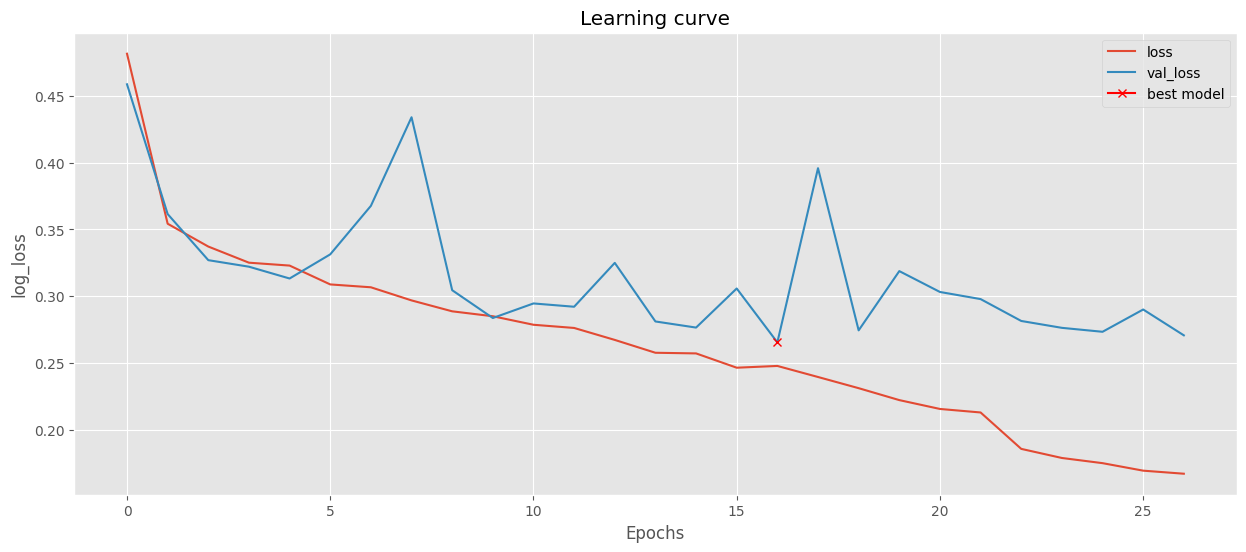

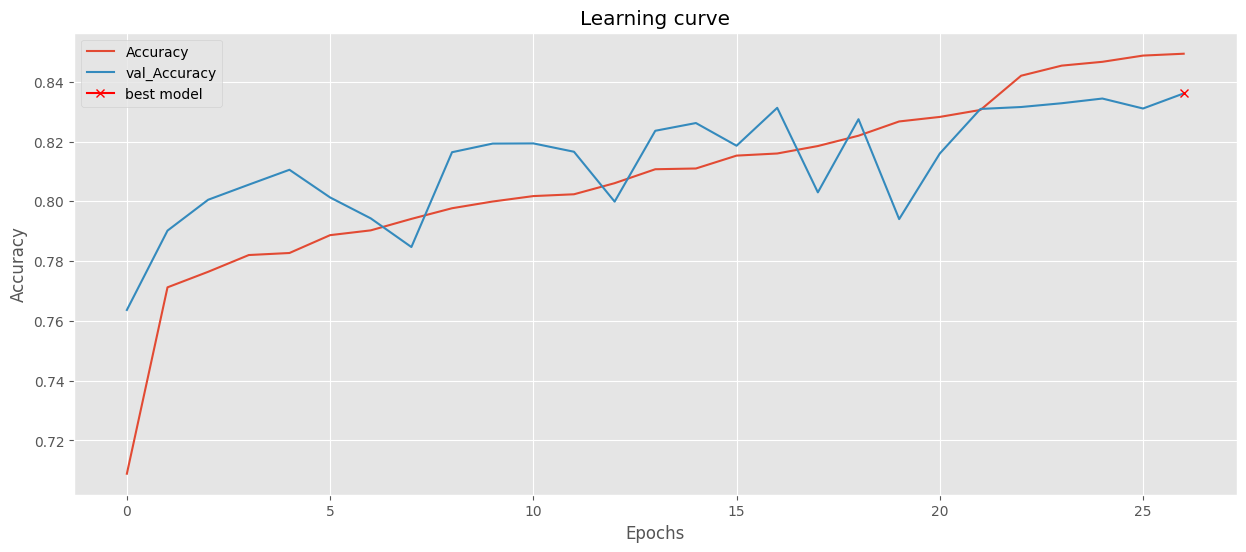

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

# **Inference**

In [ ]:
model.load_weights('model-Unet.h5')

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

4/4 [==============================] - 14s 836ms/step - loss: 0.2654 - accuracy: 0.8313 - auc: 0.8786 - sensitivity_at_specificity: 0.9243 - specificity_at_sensitivity: 0.9642


[0.2654154300689697,
 0.8313083052635193,
 0.8785884380340576,
 0.9243196249008179,
 0.9642202854156494]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

4/4 [==============================] - 0s 60ms/step


In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Actual Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title(" Image Predicted")
    ax[2].set_axis_off()

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Mask Image Predicted binary');
    ax[3].set_axis_off()
    print("Dice Coefficient: " , get_dice(y[ix].squeeze(),binary_preds[ix].squeeze()))

In [ ]:
def get_dice(mask1, mask2):
    mask1 = mask1.flatten()
    mask2 = mask2.flatten()
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice

Dice Coefficient:  0.478


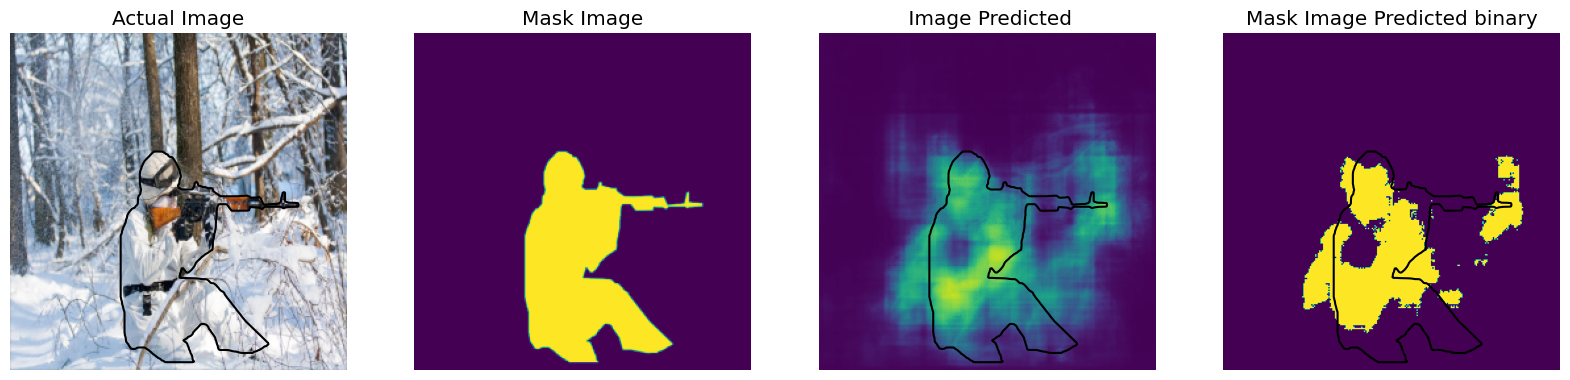

In [ ]:
plot_sample(X_test, y_test, preds_val, preds_val_t)

Dice Coefficient:  0.553


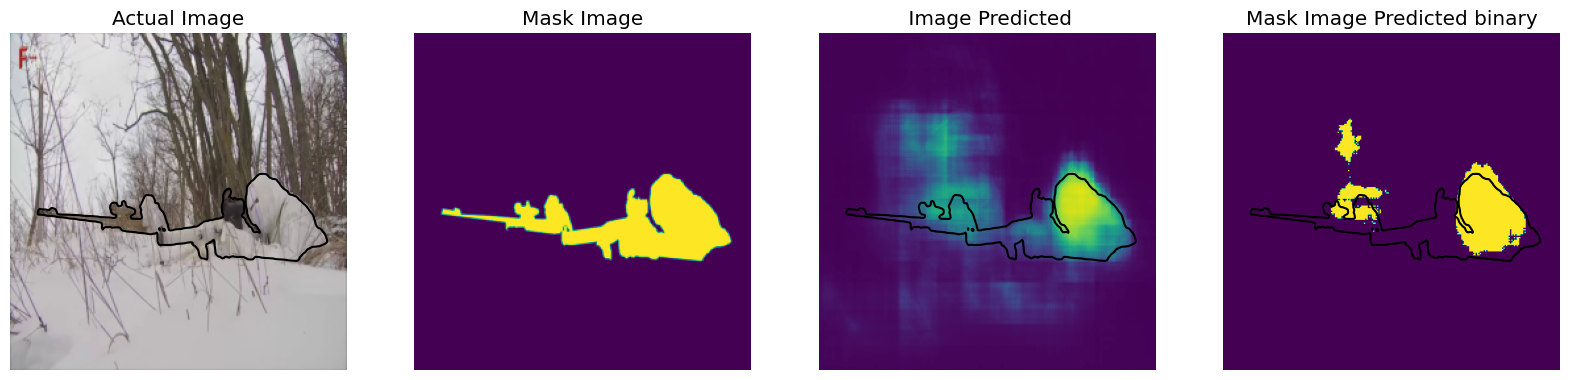

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

Dice Coefficient:  0.643


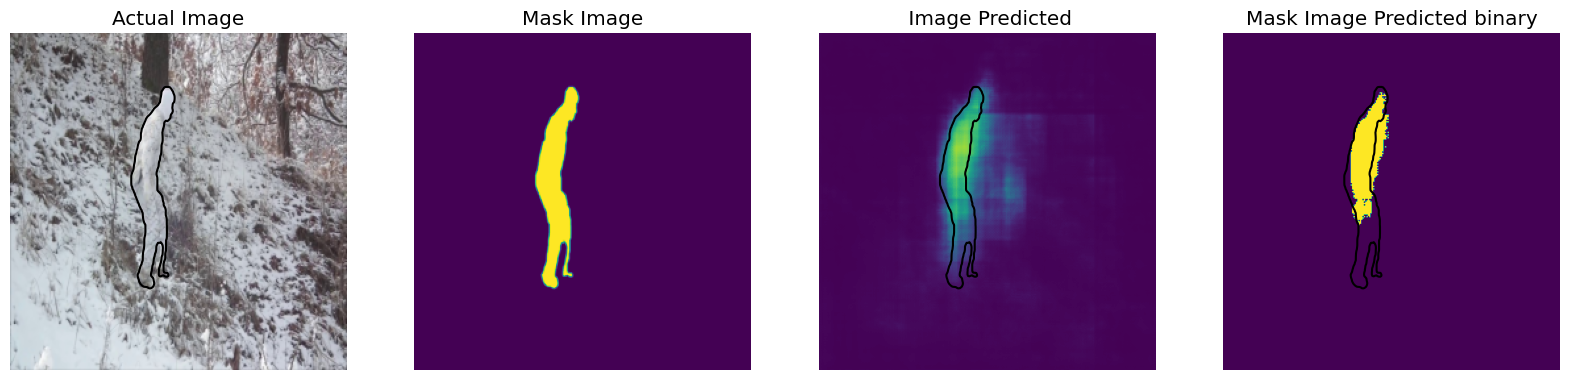

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

Dice Coefficient:  0.665


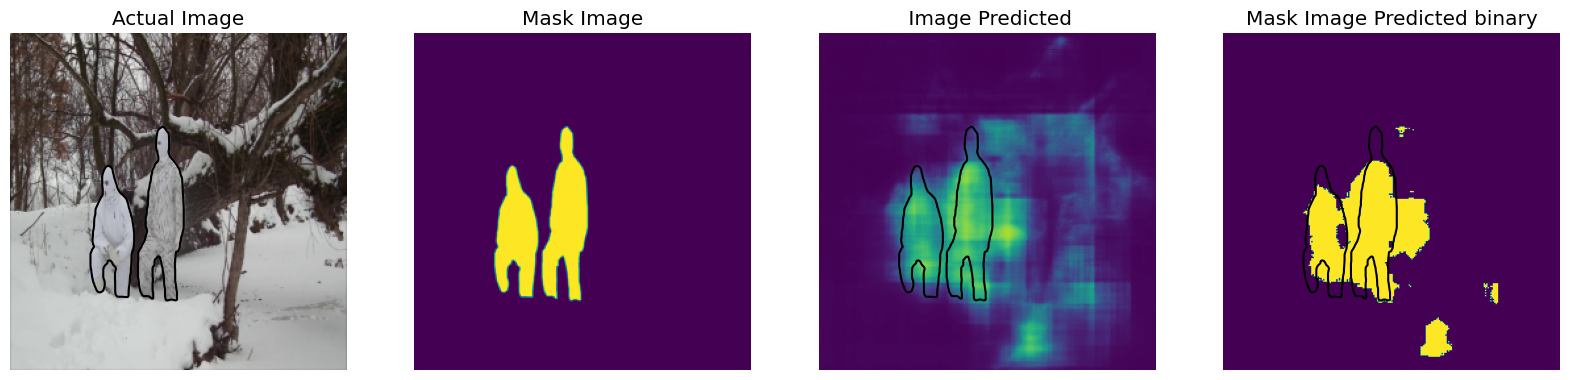

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

Dice Coefficient:  0.397


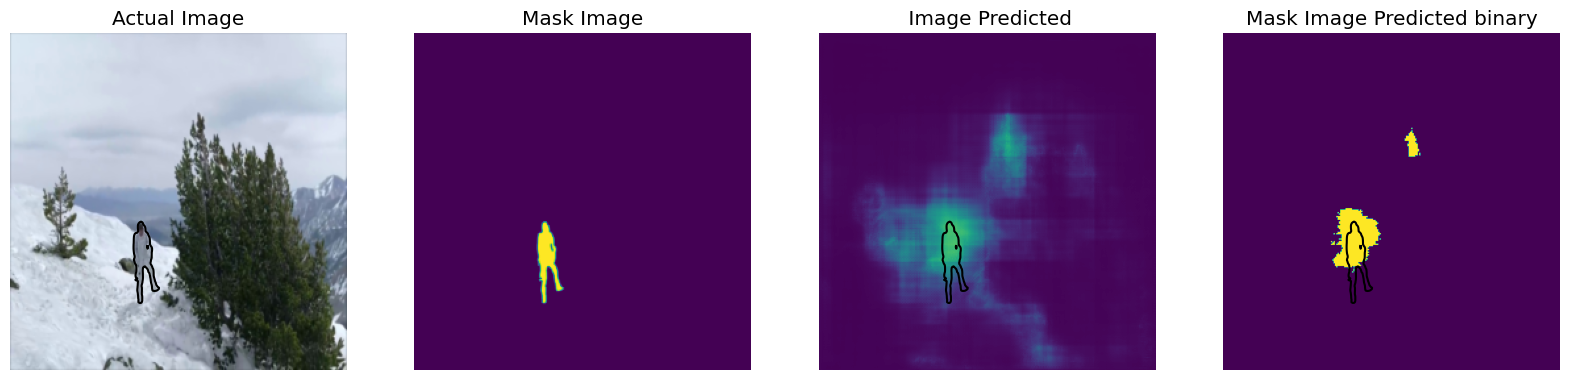

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

Dice Coefficient:  0.649


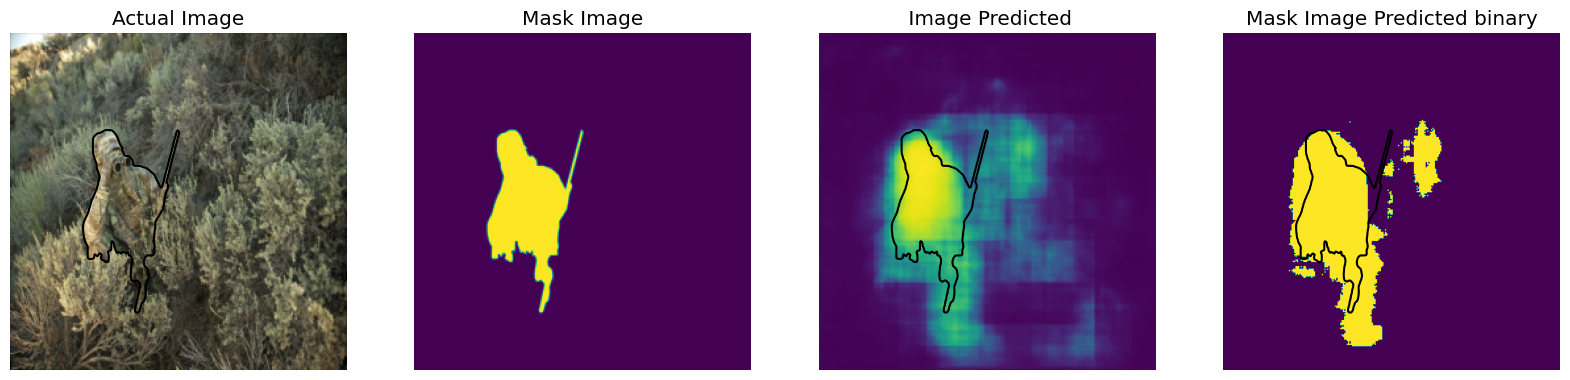

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

Dice Coefficient:  0.426


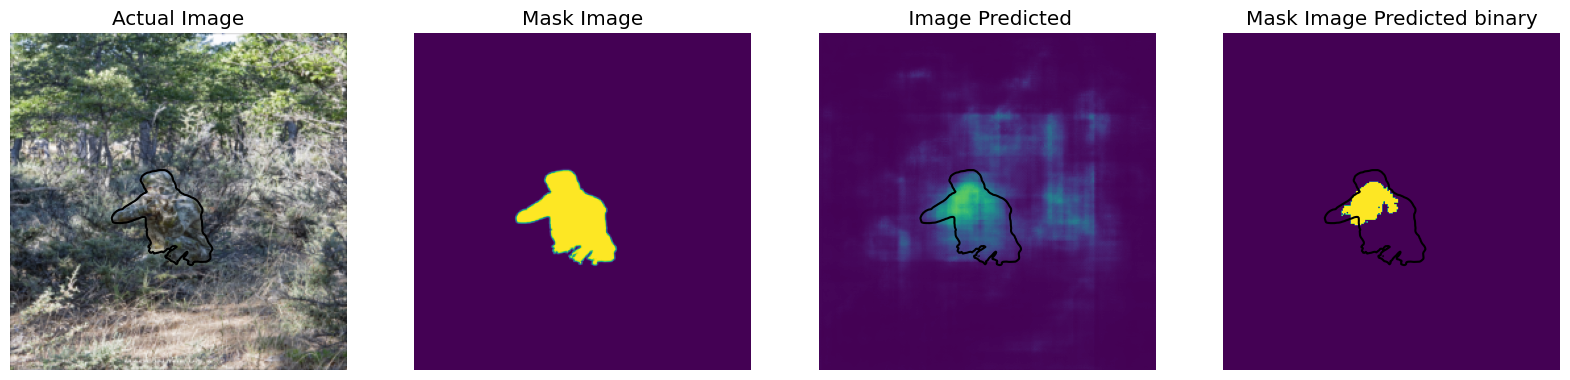

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
# Testing actual real images from google

In [ ]:
img = load_img("/content/drive/MyDrive/Military_Dataset/real_data.jpg")
x_img = img_to_array(img)
x_img = resize(x_img, (256, 256, 3), mode = 'constant', preserve_range = True)
x_img =x_img/255.0

In [ ]:
x_img.shape

(256, 256, 3)

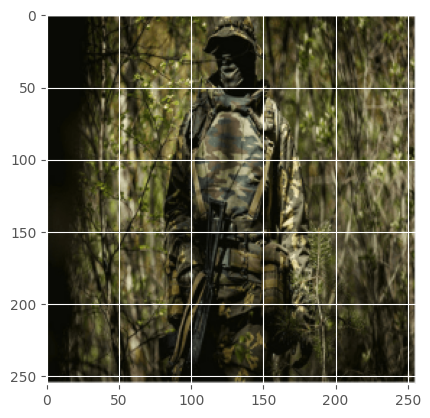

In [ ]:
plt.imshow(x_img)
plt.show()

In [ ]:
dataset1 = tf.data.Dataset.from_tensor_slices([x_img]).batch(32)

In [ ]:
real_test = model.predict(dataset1, verbose=1)
# model.input_shape

1/1 [==============================] - 1s 842ms/step


In [ ]:
binary = (real_test > 0.5).astype(np.uint8)

Dice Coefficient:  0.757


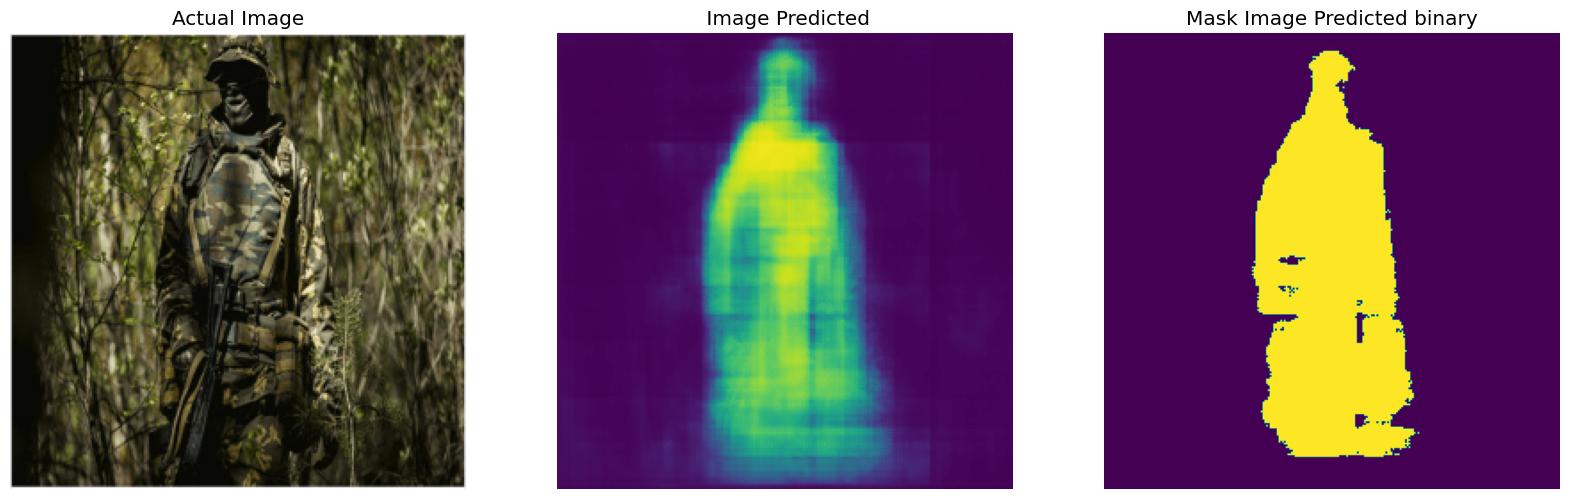

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

ax[0].imshow(x_img)
ax[0].set_title('Actual Image')
ax[0].set_axis_off()

ax[1].imshow(real_test.squeeze(), vmin=0, vmax=1)
# if has_mask:
#     ax[1].contour(real_test.squeeze(), colors='k', levels=[0.5])
ax[1].set_title(" Image Predicted")
ax[1].set_axis_off()

ax[2].imshow(binary.squeeze(), vmin=0, vmax=1)
# if has_mask:
#     ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
ax[2].set_title('Mask Image Predicted binary');
ax[2].set_axis_off()
print("Dice Coefficient: " , get_dice(real_test.squeeze(),binary.squeeze()))